In [43]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from bs4 import BeautifulSoup
import requests

from openai import OpenAI
from InfrontConnect import infront
import datetime
import re

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

In [15]:
infront.InfrontConnect(user = "", password = "") # Input for InfrontAPI (optional)


 Connected to Infront Desktop API for Python 3 version 1.0.11
**Disclaimer** 
 End-User agrees not to redistribute any such Information and to comply with any 
 restrictions placed on such information by the providers thereof, hereunder but 
 not limited to acceptance of and compliance with Data Providers’ and/or other 
 third party license agreements. 
 Customer agrees to indemnify and keep indemnified Infront and its affiliates harmless 
 from and against any loss, damage, liability, cost, charges and expenses, including 
 reasonable legal fees, arising out of any breach on part of Customer with respect to 
 its obligations to obtain prior approvals from appropriate Data Providers and to 
 comply with any applicable, conditions, restrictions, or limitations imposed by such 
 Data Providers. 


In [2]:
#OpenAI API - Used to consolidate our scraped data

client = OpenAI(api_key="") # OpenAI API key

def chat_gpt_bot(client, instructions, prompt):
    completion = client.chat.completions.create(model="gpt-4-turbo-preview",
                                               messages=[
                                                   {"role": "system", "content": instructions},
                                                   {"role": "user", "content": prompt}
                                               ])
    return completion

In [3]:
# Simpler version of the scraper - Scrapes only thread title and number of comments

def bs_scraper_threads(url):
    threads = []
    key = "a.bn_thread__link.js-threadLink"

    pages = int(input("How many pages are there currently? "))


    driver = webdriver.Chrome()
    driver.maximize_window()
    driver.get(url)

    cookie_button = "button#didomi-notice-agree-button"
    policy_button = "a.bn_header__welcome__close-button"
    next_page_button = "a.material-icons.next"


    WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.CSS_SELECTOR, cookie_button)))

    cookie_element = driver.find_element(By.CSS_SELECTOR, cookie_button) 

    driver.execute_script("arguments[0].scrollIntoView(true);", cookie_element)
    driver.execute_script("arguments[0].click();", cookie_element)


    WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.CSS_SELECTOR, policy_button)))

    policy_element = driver.find_element(By.CSS_SELECTOR, policy_button) 

    driver.execute_script("arguments[0].scrollIntoView(true);", policy_element)
    driver.execute_script("arguments[0].click();", policy_element)



    for i in range(pages+1):
        try:
            WebDriverWait(driver, 10).until(
                lambda d: d.find_element(By.CSS_SELECTOR, key)
            )
        except TimeoutException:
            print("Timeout... Trying to proceed anyway...")

        soup = BeautifulSoup(driver.page_source, "lxml")
        containers = soup.select(key)

        for j in containers:
            threads.append(j.text)

        np_element = driver.find_element(By.CSS_SELECTOR, next_page_button)

        if i < pages+1:
            np_element = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.CSS_SELECTOR, next_page_button))
            )
            driver.execute_script("arguments[0].scrollIntoView(true);", np_element)
            driver.execute_script("arguments[0].click();", np_element)
    
    driver.quit()


    threads = list(set(threads))
    return threads

In [4]:
# Slightly more advanced scraper - Scrapes every thread and all text inside each thread

def bs_scraper_text(url):
    threads = []

    pages = int(input("How many pages are there currently on the forum? "))

    driver = webdriver.Chrome()
    driver.maximize_window()
    driver.get(url)

    cookie_button = "button#didomi-notice-agree-button"
    policy_button = "a.bn_header__welcome__close-button"
    WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.CSS_SELECTOR, cookie_button))).click()
    WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.CSS_SELECTOR, policy_button))).click()

    next_page_button = "a.material-icons.next"
    thread_button = "a.bn_thread__link.js-threadLink"

    for i in range(pages):
        scraped_threads = 0
        total_threads_on_page = WebDriverWait(driver, 10).until(
            EC.presence_of_all_elements_located((By.CSS_SELECTOR, thread_button))
        )
        total_threads_count = len(total_threads_on_page)

        while scraped_threads < total_threads_count:
            thread_elements = WebDriverWait(driver, 10).until(
                EC.presence_of_all_elements_located((By.CSS_SELECTOR, thread_button))
            )

            if scraped_threads < len(thread_elements):
                thread_element = thread_elements[scraped_threads]
                driver.execute_script("arguments[0].scrollIntoView(true);", thread_element)
                driver.execute_script("arguments[0].click();", thread_element)

                WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, "h1")))

                thread_soup = BeautifulSoup(driver.page_source, "lxml")
                title = thread_soup.select_one("h1").text.strip()
                initial_text = thread_soup.select_one("div.textArea.bn_thread-body__text").text.strip()

                comments = [comment.text.strip() for comment in thread_soup.select("div.bn_thread-comment__text")]

                threads.append(title)
                threads.append(initial_text)
                for comment in comments:
                    threads.append(comment)
                

                scraped_threads += 1

                driver.back()
                WebDriverWait(driver, 10).until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, thread_button)))
            else:
                break

        if i < pages - 1:
            next_page = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.CSS_SELECTOR, next_page_button))
            )
            driver.execute_script("arguments[0].click();", next_page)
            WebDriverWait(driver, 10).until(
                EC.presence_of_all_elements_located((By.CSS_SELECTOR, thread_button))
            )

    driver.quit()
    
    threads = list(set(threads))
    
    return threads

## DataFrame creation and Chat GPT analysis

In [83]:
# Role and instructions to ChatGPT
role = "Du är en dataanalytiker som specialiserar dig i att rensa och framställa data från pythonkod. Du tar din tid, men du följer alltid instruktioner ord för ord."

instruction1 = """Du kommer få en lista genererad med python med information från Börssnack 
                    (ett aktie och börsforum) scrapad med hjälp av Python-kod. Listan innehåller 
                    titel på trådarna samt hur många kommentarer som har lagts på varje tråd. 
                    
                    Jag vill att du tar listan och sammanställer det snyggt i ett strukturerat ark med 
                    varje ämne och hur många kommentarer som lagts på varje ämne. Finns det alltså två 
                    trådar som berör samma ämne (behöver inte vara exakt samma titel, du får bedöma),  
                    sätt då ihop dem och summera antal kommentarer, glöm bara inte att skriva hur många
                    trådar som gjorts.
                    
                    VIKTIGT: Om det är flera bolag i en tråd ska du dela upp dem i ditt ark med samma 
                    antal kommentarer på varje. Om ämnet handlar om bolag ska det tecknas i ett ord, 
                    om det handlar om makro ska du sammanfatta ämnet i tre ord. """

instruction2 = """Generera pythonkod som går att göra till en DataFrame med ämnen och antal 
                kommentarer. Columner bör vara ÄMNE | KOMMENTARER | TRÅDAR | M/B | TICKER | LISTA 
                
                ÄMNE är ämnet - Alla ämnen ska in, både makro och bolag. 
                
                KOMMENTARER är totoal antal kommentarer. 
                
                TRÅDAR är hur många trådar som har gjorts om ämnet. 
                
                M/B ska känneteckna om diskussionen handlar om ett bolag eller makro.  
                
                TICKER är bolagets börsticker (om det är ett bolag), du måste kolla upp 
                vilken ticker bolagen har. 
                
                LISTA anger vart bolaget är listat någonstans, alltså i vilket land 
                som är bolagets huvudlista.
                
                Du ska ta fram TICKER och LISTA för varje ämne som är inom kategorin bolag (inga np.nans).
                Är ämnet makro behövs däremot varken TICKER eller BÖRS, så applicera np.nan. 
                
                Jag vill att du enbart printar dataframen i fråga, inga förtydliganden eller exempel. 
                Den ska vara i sin helhet så pass att man ska kunna kopiera och klistra in den.
            """

# scraping Börssnack
url = "https://borssnack.di.se/#/"
context = bs_scraper_threads(url)
completion1 = chat_gpt_bot(client, "Hjälpreda", instruction1+"\n"+str(context))

print(completion1.choices[0].message.content)

completion2 = chat_gpt_bot(client, role, instruction2+"\n"+str(completion1.choices[0].message.content))

print(completion2.choices[0].message.content)

How many pages are there currently? 4
För att sammanställa och strukturera informationen från den angivna listan i ett snyggt ark, kommer jag att gruppera trådarna baserat på ämnen eller bolagsnamn, summera antalet kommentarer där ämnen överlappar och dela upp kommentarer jämnt där flera bolag nämns i samma tråd. På grund av formatet här, kommer jag att presentera informationen i textform men den kan enkelt överföras till ett kalkylark i en verklig situation. 

### Sammanställd Lista:
1. **Ncc** - Kommentarer: 4
2. **Försvarsaktier** - Kommentarer: 32 (Försvarsaktier och Vilka svenska fonder stöder svensk vapenindustri? sammanlagt)
3. **EasyFill** - Kommentarer: 2
4. **ProfilGruppen** - Kommentarer: 1 (Q4:2023)
5. **Lyko Group AB** - Kommentarer: 9 (Delårs!)
6. **Hanza** - Kommentarer: 9 (Hanza: Q4-2023, HANZA reviderar, Rapport Hanza, HANZA rapport så dålig? sammanlagt)
7. **Banker** - Kommentarer: 3 (Bankernas bolånemarginaler)
8. **Clinical Laserthermia Systems** - Kommentarer: 9
9.

In [1]:
# Paste in the dataframe created by the former cell here


## Data Vizualization of outputted DataFrame

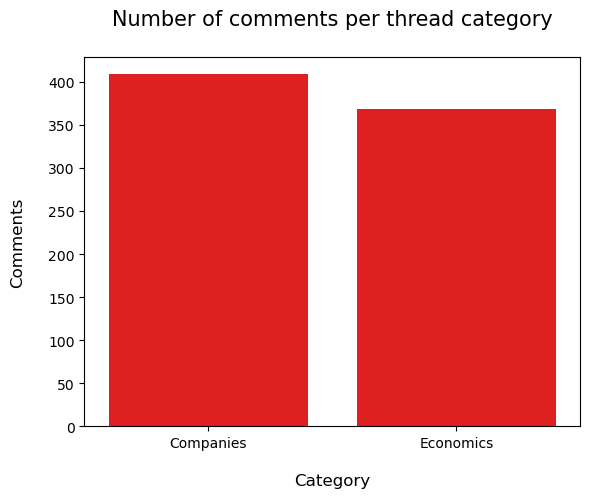

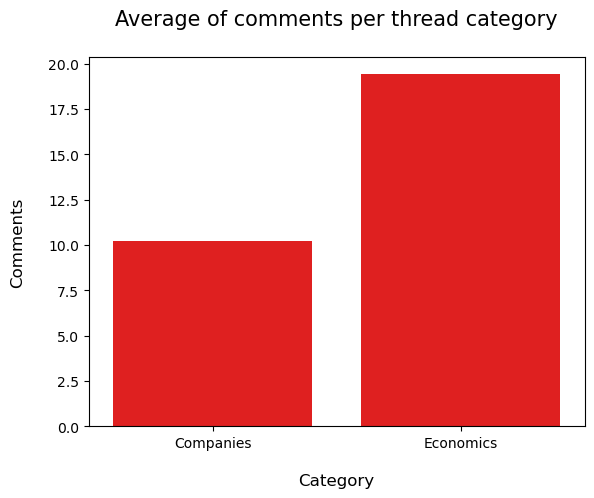

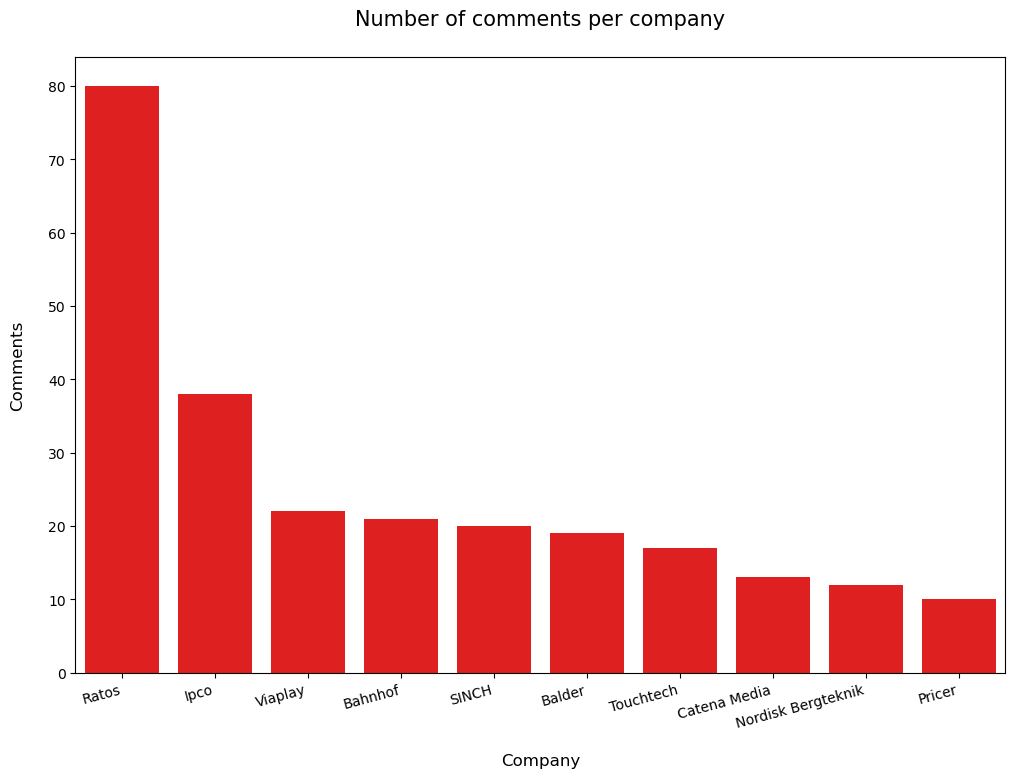

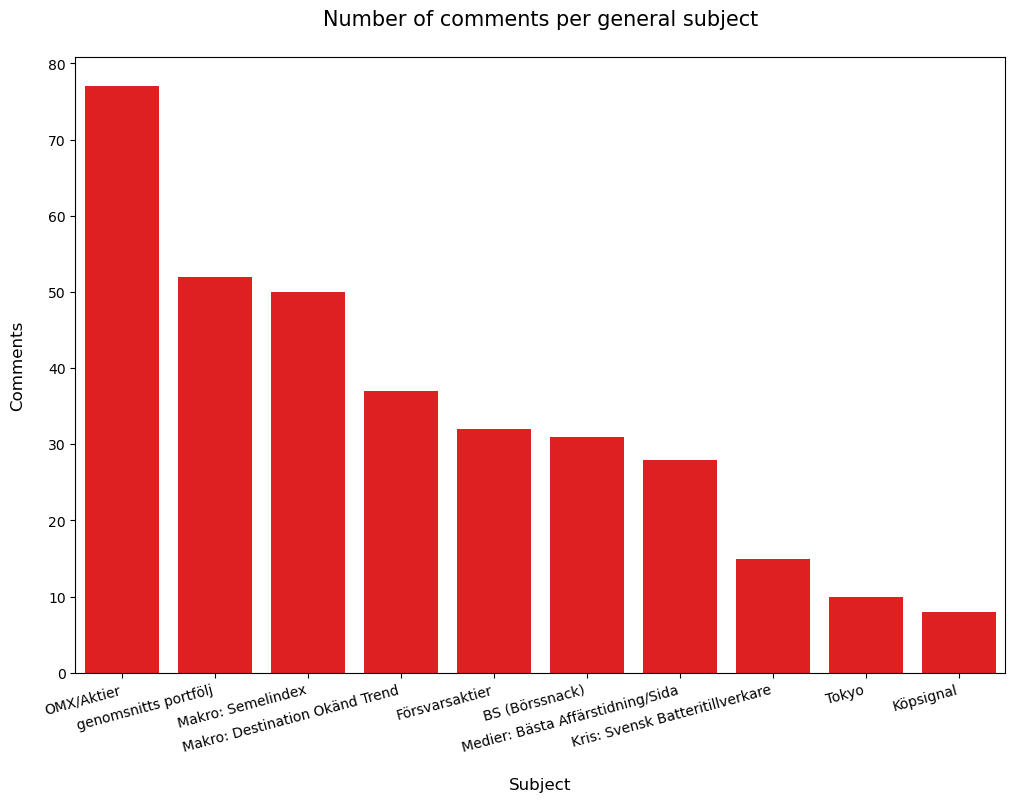

In [97]:
# Some general vizualisation code for the output

temp = df.groupby("M/B")[["KOMMENTARER"]].sum()

plt.title("Number of comments per thread category\n", fontsize=15)
sns.barplot(data=temp, x="M/B", y="KOMMENTARER", color="Red")
plt.xlabel("\nCategory", fontsize=12)
plt.ylabel("Comments\n", fontsize=12)

custom_labels = ["Companies", "Economics"]  # Example labels
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels)

plt.show()

temp = df.groupby("M/B")[["KOMMENTARER"]].mean()

plt.title("Average of comments per thread category\n", fontsize=15)
sns.barplot(data=temp, x="M/B", y="KOMMENTARER", color="Red")
plt.xlabel("\nCategory", fontsize=12)
plt.ylabel("Comments\n", fontsize=12)

custom_labels = ["Companies", "Economics"]  # Example labels
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels)

plt.show()

mask = df["M/B"] == "B"

temp = df.loc[mask]

temp = temp.groupby("ÄMNE")[["KOMMENTARER"]].sum()

temp.drop(index="AA Effekten (Aktieanalytikern)", inplace=True)

plt.figure(figsize=(12,8))
plt.title("Number of comments per company\n", fontsize=15)
sns.barplot(data=temp, x="ÄMNE", y="KOMMENTARER", color="Red", order=list(temp["KOMMENTARER"].nlargest(10).index))
plt.xlabel("\nCompany", fontsize=12)
plt.ylabel("Comments\n", fontsize=12)
plt.xticks(rotation=15, ha="right")

plt.show()

mask = df["M/B"] == "B"

temp = df.loc[~mask]

temp = temp.groupby("ÄMNE")[["KOMMENTARER"]].sum()

plt.figure(figsize=(12,8))
plt.title("Number of comments per general subject\n", fontsize=15)
sns.barplot(data=temp, x="ÄMNE", y="KOMMENTARER", color="Red", order=list(temp["KOMMENTARER"].nlargest(10).index))
plt.xlabel("\nSubject", fontsize=12)
plt.ylabel("Comments\n", fontsize=12)
plt.xticks(rotation=15, ha="right")

plt.show()

What's the ticker? RATO B
What's the feed? SSE


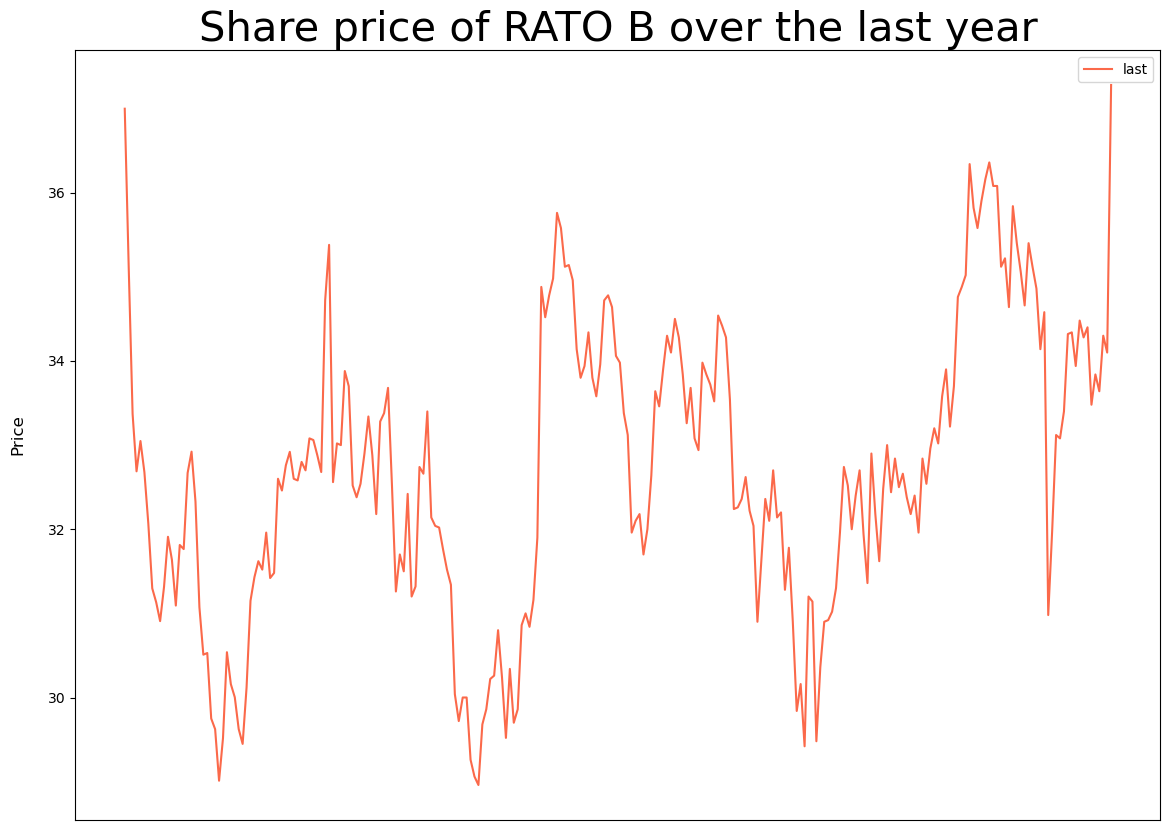

In [108]:
#Getting infront price data from tickers generated by OpenAI API

today = datetime.date.today()
today_str = today.strftime('%Y-%m-%d')

today_y = today - datetime.timedelta(days=365)
today_y_str = today_y.strftime('%Y-%m-%d')

ticker = input("What's the ticker? ")
feed = input("What's the feed? ")

share = infront.GetHistory(tickers = [f"{feed}:{ticker}"], fields = ["last"], 
                   start_date = today_y_str, end_date = today_str)

share = share[f"{ticker}"]

plt.figure(figsize=(14,10))
plt.title(f"Share price of {ticker} over the last year", fontsize=30)
sns.lineplot(data=share, palette="Reds")
plt.xticks([])
plt.xlabel("", fontsize=12)
plt.ylabel("Price\n", fontsize=12)

plt.show()

## Text scraping

In [109]:
# scraping Börssnack
url = "https://borssnack.di.se/#/"
word_content = bs_scraper_text(url)

How many pages are there currently on the forum? 4


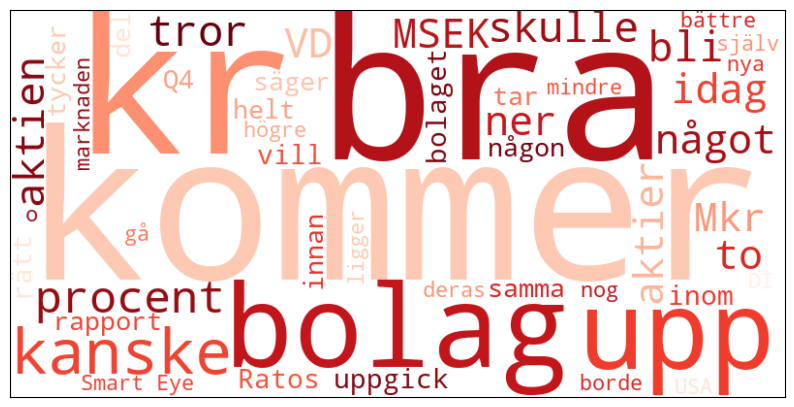

In [116]:
jstrings = " ".join(word_content)

stopwords = [
    'och', 'i', 'på', 'är', 'det', 'som', 'till', 'för', 'med', 'att', 'en', 'av', 'inte', 'den', 'så', 'har', 'om',
    'ett', 'men', 'vi', 'du', 'de', 'kan', 'jag', 'var', 'sig', 'från', 'detta', 'vid', 'eller', 'man', 'efter', 'också',
    'under', 'mer', 'mot', 'över', 'mycket', 'när', 'utan', 'hade', 'varit', 'oss', 'Redigerad', '@', 'https', 'www',
    '.com', '\xa0', 'han', 'ju', 'då', 'vara', 'nu', 'hur', 'ska', 'vad', 'bara', 'där',
    'även', 'in', 'blir', 'väl', 'här', 'får', 'finns', 'än', 'ha', 'lite', 'alla', 'år', 'gör', 'allt', 'går',
    'Ja', 'denna', 'mig', 'få', 'göra', 'the', 'sen', 'ca', 'sin', 'dessa', 'redan', 'a', 'B', 'dig',
    'ut', 'sedan', 'se', 'dock', 'andra', 'ser', 'vilket', 'många', 'min', 'några', 'tidigare', "and", "dom",
    "ta", 
]

# Feel free to add more stopwords

wc = WordCloud(stopwords=stopwords, 
               background_color = "White", 
               max_words=50,
               colormap='Reds',
               width=800,
               height=400)

wc.generate(jstrings)
        
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation='bilinear')
plt.xticks([])
plt.yticks([]) 
plt.show()